## CS:GO Player Form Prediction

To accompany our article/blog, this notebook is designed to show how we can use the simple variables such as the number of kills and deaths a player has in a given game in order to predict how they "should" perform on their next game. We first do a bunch of preprocessing and data manipulation. Then we use a recurrent neural network (specifically LSTM) to predict our measure of player form. Our real model of player form incorporates many more variables that we have extracted from the demo files of professional games, which give greater insight into player form than kills/deaths alone.

But anyway here is an open and fun way to look at using data to predict the outcome of professional CSGO matches

In [1]:
# Python imports
import pandas as pd
import numpy as np
import csv



*Le data imports* 

Clearly you need to have the correct "matchdata" csv file in the same directory as this notebook...

In [2]:
dat = pd.read_csv('matchdata.csv',encoding = "ISO-8859-1")

/home/max/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (82,83,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Variable Names...

Here we can see a nice list of all the variables that our data gives us

In [3]:
#list(dat.columns.values)

In [4]:
# Need a function that pulls out only a certain teams data:

def team_data(team): # probably by index...
    df = dat.loc[(dat.ix[:,3] == team) |  (dat.ix[:,4] == team) ]
    return(df)

# make a player data one...

def player_data(player): # can define by indx later as well...
    df = dat.loc[(dat.ix[:,11] == player) |  (dat.ix[:,17] == player)|  (dat.ix[:,23] == player)|  (dat.ix[:,29] == player)|  (dat.ix[:,35] == player)|  (dat.ix[:,41] == player) |  (dat.ix[:,47] == player) |  (dat.ix[:,53] == player) |  (dat.ix[:,59] == player) |  (dat.ix[:,65] == player)]
    return(df)

# make function that says which team a player is on (1 or 2)...
def player_side(player, match): # match is the match # as integer

    dato = player_data(player).reset_index(drop=True) 
    N = len(dato)
    i = match
    
    side = []
    # loop over each row...
    if( (dato.ix[i,11] == player) |  (dato.ix[i,17] == player)|  (dato.ix[i,23] == player)|  (dato.ix[i,29] == player)|  (dato.ix[i,35] == player) ):
        side = 1
    elif( (dato.ix[i,41] == player) |  (dato.ix[i,47] == player) |  (dato.ix[i,53] == player) |  (dato.ix[i,59] == player) |  (dato.ix[i,65] == player) ):
        side = 2
    else:
        side = 0
    return(side)


def team_score(player, match):
    '''
    Returns team scores, enemy scores and team deaths (TD)...
    '''
    
    side = player_side(player, match)
    dato = player_data(player).reset_index(drop=True) 
    i = match
    if(side == 1):
        teamscore = dato.ix[match,6] +dato.ix[match,8]
        enemyscore = dato.ix[match,7] + dato.ix[match,9]
        TK = (dato.ix[i,12]) + (dato.ix[i,18])+  (dato.ix[i,24])+(dato.ix[i,30])+ (dato.ix[i,36])
        TD = (dato.ix[i,13] == player) + (dato.ix[i,19])+  (dato.ix[i,25])+(dato.ix[i,31])+ (dato.ix[i,37])
        
    elif(side ==2 ):
        teamscore = dato.ix[match,7] +dato.ix[match,9]
        enemyscore = dato.ix[match,6] +dato.ix[match,8]
        TK = dato.ix[i,42] + (dato.ix[i,48])+  (dato.ix[i,54])+(dato.ix[i,60] )+ (dato.ix[i,66])
        TD = dato.ix[i,43]+ (dato.ix[i,19])+  (dato.ix[i,55])+(dato.ix[i,61] )+ (dato.ix[i,67])
        
    else:
        teamscore = "ERROR"
        enemyscore = "UNLUGGY UCE"
        
        
    return( teamscore, enemyscore, TK, TD)



In [5]:
TS, ES, tk, td = team_score('GeT_RiGhT', 10)

print('team score is:', TS )
print('enemy score is:', ES )
print('team kills are:', tk )
print('team deaths are:', td)


team score is: 16
enemy score is: 7
team kills are: 89.0
team deaths are: 76.0


In [141]:
'''
get_metrics returns the players kills, KDR, teamscore, enemyscore, team kills and enemy kills at specified time...
'''
def get_metrics(player, match):
    TS, ES, tk, td = team_score(player, match)
    # get the new player 
    dato = player_data(player).reset_index(drop=True) 
    i = match
    if( dato.ix[i,11] == player ):
        kills = dato.ix[i,12]
        deaths = dato.ix[i,13]
        kd = dato.ix[i,12]/dato.ix[i,13]    
    elif( dato.ix[i,17] == player ):
        kills = dato.ix[i,18]
        deaths = dato.ix[i,19]
        kd = dato.ix[i,18]/dato.ix[i,19]
    elif( dato.ix[i,23] == player ):
        kills = dato.ix[i,24]    
        deaths = dato.ix[i,25]
        kd = dato.ix[i,24]/dato.ix[i,25]
    elif( dato.ix[i,29] == player ):
        kills = dato.ix[i,30]  
        deaths = dato.ix[i,31]
        kd = dato.ix[i,30]/dato.ix[i,31]
    elif( dato.ix[i,35] == player ):
        kills = dato.ix[i,36]
        deaths = dato.ix[i,37]
        kd = dato.ix[i,36]/dato.ix[i,37]
    elif( dato.ix[i,41] == player ):
        kills = dato.ix[i,42]    
        deaths = dato.ix[i,43]
        kd = dato.ix[i,42]/dato.ix[i,43]
    elif( dato.ix[i,47] == player ):
        kills = dato.ix[i,48]       
        deaths = dato.ix[i,49]
        kd = dato.ix[i,48]/dato.ix[i,49]
    elif( dato.ix[i,53] == player ):
        kills = dato.ix[i,54]      
        deaths = dato.ix[i,55]
        kd = dato.ix[i,54]/dato.ix[i,55]
    elif( dato.ix[i,59] == player ):
        kills = dato.ix[i,60] 
        deaths = dato.ix[i,61]
        kd = dato.ix[i,60]/dato.ix[i,61]
    elif( dato.ix[i,65] == player ):
        kills = dato.ix[i,66] 
        deaths = dato.ix[i,67]
        kd = dato.ix[i,66]/dato.ix[i,67]        
     
    k_TK = kills / tk
    kDR_A = kd / (np.log(1+TS)*(TS - ES+1))
    p_p = np.log(((kills*kills)/(deaths)+1))+np.log(((k_TK)*(kDR_A))/(deaths/td)+1)
    
    return(kills, deaths, kd, TS, ES, tk ,td, k_TK, kDR_A, p_p)            
                
'''
Now make function that makes CSV/df for the player and their past performance...
'''   

def make_inputs(player): # uses the player and gets all inputs from this...
    datta = player_data(player).reset_index(drop=True) 
    N = np.shape(datta)[0] # length of the data frame...
    
    # initialize the vectors...
    kill = []
    kdr = []
    scorediff = []
    kill_cont = [] # contribution of kills
    death_cont = [] # contriubution of deaths
    kdr_adjust = []
    player_perf = []
    
    print(N)
    
    # loop over each row to get data:
    for row in range(N):
        k,d,KDR, TS,ES,tk,td,k_TK,kDR_A, p_p = get_metrics(player, row)
        kill.append(k)
        kdr.append(KDR)
        scorediff.append(TS-ES)
        kill_cont.append(k_TK)
        death_cont.append(d/td)
        kdr_adjust.append(kDR_A)
        player_perf.append(p_p)
        
    # add all as columns to the dataframe...    
    newdat = pd.DataFrame([kill,kdr,scorediff,kill_cont, death_cont, kdr_adjust, player_perf])
    
    # but data is a tensor - so turn into tensor
    
    return(newdat)

In [64]:
#frame = make_inputs('fnx') # save as "frame" to use in function later - although will really call this from inside the function for 
# get_tensor
#get_metrics('GeT_RiGhT',3)
np.transpose(make_inputs('fnx'))

277


,0,1,2,3,4,5,6
0,21.0,1.166667,-4.0,0.238636,0.193548,-0.151617,3.031733
1,15.0,0.833333,4.0,0.159574,0.246575,0.058826,2.640053
2,20.0,1.111111,-7.0,0.303030,0.225000,-0.080425,3.030466
3,19.0,1.187500,5.0,0.182692,0.186047,0.069856,3.226003
4,23.0,1.352941,5.0,0.232323,0.195402,0.079588,3.559819
5,23.0,0.958333,0.0,0.186992,0.258065,0.345646,3.360810
6,25.0,3.571429,11.0,0.280899,0.159091,0.105046,4.673123
7,30.0,3.333333,9.0,0.312500,0.121622,0.117652,4.879253
8,17.0,0.850000,-5.0,0.202381,0.246914,-0.085516,2.664939
9,14.0,0.823529,-9.0,0.202899,0.193182,-0.049504,2.474684


## TENSORRRRRRRRRRZZZZZZZZZZZZZ

*Le Tensor* construction. Imagine a matrix, now imagine a stack of matrices for each input sample - we also make sure to zero-pad the input matrices, this way we have conformable arrays when implementing the recurrent net


In [142]:
def get_tensor(dataframe, K = 7, T = "default"):  # standardize the T window size, and K variables...
    '''
    T is window size
    K is number of input variables...
    N is number of input samples...
    '''
    dataframe = np.transpose(dataframe)
    N = np.shape(dataframe)[0] # umber of samples
    if(T == "default"):
        T = N # standardize T window
    # otherwise we have already defined T by function...
        
    tens = np.zeros((N,T,K)) # iniitalizes tensor shape... (From a given 'N', and known 'T' and 'K')

    '''
    basically need to generate a new dataframe for each 'N'...
    N is given by the number of time steps as well - as T
    ...
    each dataframe is an NxK array of zeros (using np.zeros)   
    '''

    # loop over each N:

    for i in range(N):

        # generate dataframe of zeros
        df = np.zeros((T,K)) # this is of size  K by T...
    
        # add for the first one...
        df[0] = dataframe.ix[(N-1-i),:K] # since frame is a pandas dataframe... (from make_inputs command...)
        # the second one...
        for j in range(1,N-i):
            df[j] = dataframe.ix[(N-i-j-1),:K] # since frame is a pandas dataframe... (from make_inputs command...)
        
        tens[i] = df # adds to the tensor...
    '''
    The result of this will be fed into get_targs... (Just FYI)
    '''
    #return(np.shape(tens)) # return the shape of the tensor - change to the actual tensor if working correct..
    return(tens)  # add this instead of above line if want actual tensor output...
    # it works!! (well the shape says so) so we will return the actual object instead ^^
               
        
def form_calc(kill,kdr,scorediff,kill_cont, death_cont, kdr_adjust):
    '''
    This calculates the form of a player given the input variables...
    '''
    # score = np.log((K**2)/D) + np.log( ( (K/TK)*(K/D)/ np.log(1+TS)*(TS-ES) )/(D/TD) ) # - old version...
    # Need to extrapolate team score: - since the winner *usually* gets 16 this gives us
    if(scorediff < 0):
        TS = 16 + scorediff
    else:
        TS = scorediff
        
    score = np.log(kill*kdr) + np.log( ((kill_cont*kdr)/(np.log(1+TS)*scorediff))/death_cont)  # new version
    # except we are currently 
    
    return(score)
    
    # Don't need this anymore...
    
    
def get_targs(tensor): 
    '''
    This function takes the tensor, removes the final entry,
    uses that to calculate the "target" then returns a tensor of
    one less "N" size than orignally. It also returns a vector of
    targets.
    '''
    
    # get N, T and K dimensions:
    N = np.shape(tensor)[0]
    T = np.shape(tensor)[1]
    K = np.shape(tensor)[2]-1  # target is given as the final dimension - so remove...
    
    # remove last record... ()
    
    tarG = tensor[1:,0,K]  # the targs are kept... and one sample is cut from the start...
    
    inps = tensor[:N-1,:,:K-1] # inputs are kept and one sample is cut at the end... 
    
    return(tarG,inps)
    
        


In [263]:
playa = 'TACO'

TENZ = get_tensor(make_inputs(playa)) # using the data for a player

269


In [264]:
tz , iz =  get_targs(TENZ)
iz = iz[:,::-1,:]


#### Need to normalize the input data as they are being ran through a sigmoid / tanh function 

In [265]:
import math

def normalize(x_train):
    '''
    normalizes each column...
    '''
    
    # need to normalize x_train:
    for thr in range(np.shape(x_train)[2]):
        for col in range(np.shape(x_train)[1]): # iterate over each column:
            for row in range(len(x_train)):
                if math.isnan( ( x_train[row,col,thr] - np.min( x_train[:,col,thr])) / (np.max( x_train[:,col,thr]) -  np.min(x_train[:,col])) ) == True:
                    x_train[row,col,thr] = 0
                else:
                    x_train[row,col,thr] = ( x_train[row,col,thr] - np.min( x_train[:,col,thr])) / (np.max( x_train[:,col,thr]) -  np.min(x_train[:,col]))
               
                    
    return(x_train)            


## LSTM Time!

Now that we have our input data and targets we can use these to split into test and training data set, then run them through an LSTM neural network

In [266]:
def test_train(inputs, targs, perc = 30):
    '''
    Take input and target data then split them by the given percentage ratio
    "percent" must be between 1 and 50 - signalling no more training data splitting than testing 
    '''
    N = np.shape(inputs)[0]
    N_train = int( ((100 - perc) / 100 ) * N )
    # train set...
    train_i = inputs[:N_train,:,:]
    train_t = targs[:N_train]
    # test set...
    test_i =  inputs[N_train+1:,:,:]
    test_t = targs[N_train+1:]
    
    return(train_i,train_t,test_i,test_t)
    

In [267]:
train_i,train_t,test_i,test_t = test_train(iz,tz, 30.0)

In [268]:
'''
Data normalization:
Please note that this is quite an expensive algorithm...
'''
trainI = np.nan_to_num(normalize(train_i) )
testI = np.nan_to_num(normalize(test_i) )



In [269]:
train_t = np.nan_to_num(train_t)
test_t = np.nan_to_num(test_t)


### Define the LSTM Architecture

In [212]:
## keras imports 
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM,GRU

In [270]:
in_neurons = np.shape(train_i)[2]   
out_neurons = 1 # since regression output  
hidden_neurons = 3 # since 6 variables encoded...

model = Sequential()  
model.add(GRU(output_dim=hidden_neurons, input_dim= in_neurons, return_sequences=False, consume_less='gpu')) 
model.add(Dense(output_dim=out_neurons, input_dim=hidden_neurons))
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer= 'rmsprop' )  


### Train the Model

In [ ]:
model.fit(trainI, np.array(train_t) , batch_size=10, nb_epoch = 100, validation_split=0.05)  


Train on 177 samples, validate on 10 samples
Epoch 1/100
177/177 [==============================] - 1s - loss: 2.2212 - val_loss: 0.9695
Epoch 2/100
177/177 [==============================] - 1s - loss: 1.7962 - val_loss: 0.6942
Epoch 3/100
177/177 [==============================] - 1s - loss: 1.4349 - val_loss: 0.4759
Epoch 4/100
177/177 [==============================] - 1s - loss: 1.1431 - val_loss: 0.3208
Epoch 5/100
177/177 [==============================] - 1s - loss: 0.9194 - val_loss: 0.2188
Epoch 6/100
177/177 [==============================] - 1s - loss: 0.7579 - val_loss: 0.1671
Epoch 7/100
177/177 [==============================] - 1s - loss: 0.6558 - val_loss: 0.1521
Epoch 8/100
177/177 [==============================] - 1s - loss: 0.5958 - val_loss: 0.1598
Epoch 9/100
177/177 [==============================] - 1s - loss: 0.5661 - val_loss: 0.1764
Epoch 10/100
177/177 [==============================] - 1s - loss: 0.5542 - val_loss: 0.1894
Epoch 11/100
177/177 [============

In [257]:
'''
Time to predict some stuff LOL... :P
'''

predicted = model.predict(testI)  
rmse = np.sqrt(((predicted - test_t) ** 2).mean(axis=0))


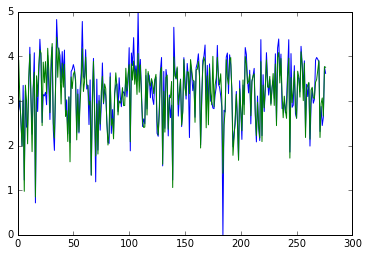

In [258]:
''' PREDICTIONS OF TRAINING DATA: '''
pred2 = model.predict(trainI)
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(pd.DataFrame(train_t[:len(pred2)-2]))
ax.plot(pd.DataFrame(pred2[:len(pred2)-2]))


# Plotting predicted Form vs Real

Blue is the real, green is predicted

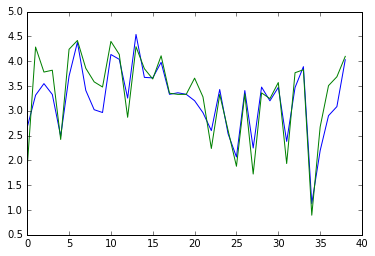

In [259]:
''' PREDICTIONS OF TESTING DATA '''

fig, ax = plt.subplots()
ax.plot(pd.DataFrame(test_t[:len(predicted)-80]))
ax.plot(pd.DataFrame(predicted[:len(predicted)-80]))


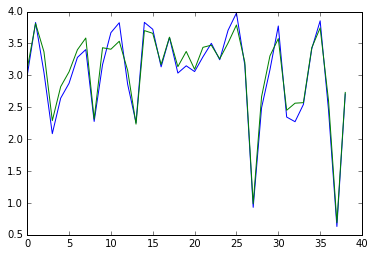

In [261]:
''' PREDICTIONS OF TESTING DATA '''
''' Another part...'''

fig, ax = plt.subplots()
ax.plot(pd.DataFrame(test_t[50:len(predicted)-30]))
ax.plot(pd.DataFrame(predicted[50:len(predicted)-30])-0.5)

In [262]:
## SAVE THE MODEL:

from keras.models import load_model

model.save(playa+'_performance_model.h5')  # creates a HDF5 file 'my_model.h5'

#del model  # deletes the existing model - uncomment when needed

# returns a compiled model
# identical to the previous one - uncomment when needed
#model = load_model('player_performance_model.h5')

In [154]:
# load back in the model
model = load_model('player_performance_model.h5')

## API Demonstration

Below shows some examples of uses from this API

In [17]:
# test form calculation with different scenarios...
# this demonstrates the use of form_calc...
'''
good - easy win
'''
p1 = form_calc( K=22,D=4,TK = 23+22+13+12+13, TD = 12+10+7+11+4,TS=16,ES = 1 )
'''
average... (slight win) Coldzera (SK) vs fnatic...
'''
p2 = form_calc( K=16,D=13,TK = 23+19+20+16+15, TD = 17+13+18+11+13,TS=16,ES = 9 )
'''
good... (slight) win) fnx (SK) vs fnatic...
'''
p3 = form_calc( K=23,D=13,TK = 23+19+20+16+15, TD = 17+13+18+11+13,TS=16,ES = 9 )

print(p1)
print(p2)
print(p3)

9.23727443252
4.04407206672
5.49569404148


#### Below it might be useful to use a lookup table of players...

This can be done by the **show_players()** command...
Which returns a frame of each player.

I haven't actually made this command yet - but is on its way!

In [ ]:
# see the fellas we can use...
show_players()

### Team_score API call

This is used as player name followed by their last nth match. i.e. team_score("Get_RiGhT",0) shows the team information from get_right's last game... 

In [34]:
TS, ES, tk, td = team_score('GeT_RiGhT', 3)

# then we can print these variables out:

print('team score is:', TS )
print('enemy score is:', ES )
print('team kills are:', tk )
print('team deaths are:', td)


team score is: 16
enemy score is: 11
team kills are: 104.0
team deaths are: 86.0


**Below needs to be turned into a function - currently just testing that the data goes into the 3 dimensional array correctly...**

In [59]:
# manually defining N T and K although they will be decided by the data we are using from "make_inputs"
N = np.shape(frame)[1]
T = N # full sized time window...
K = 6
#
tens = np.zeros((N,T,K)) # iniitalizes tensor shape... (From a given 'N', and known 'T' and 'K')
#tens[0] = np.random.randn(T,K) # this is the dataframe at first sample...

'''
basically need to generate a new dataframe for each 'N'...
N is given by the number of time steps as well - as T
...
each dataframe is a TxK array of zeros (using np.zeros)

'''

# loop over each N:
#i =  # for the 5th one...
for i in range(N):
#if True == True: # comment this out for testing...
    # generate dataframe of zeros
    df = np.zeros((T,K)) # this is of size T by K...
    
    # add for the first one...
    df[0] = frame.ix[:,N-1] # since frame is a pandas dataframe... (from make_inputs command...)
    
    for j in range(1,N-i):
        df[j] = frame.ix[:,N-i-j] # since frame is a pandas dataframe... (from make_inputs command...)
        
    tens[i] = df # adds to the tensor...


The following cells visualise how the new tensor appears and how the the original data frame looks - there are still a few patches that need fixing...

In [8]:
print(tens[1])

NameError: name 'tens' is not defined

In [57]:
print(frame)

         0          1          2          3          4          5    \
0  21.000000  15.000000  20.000000  19.000000  23.000000  23.000000   
1   1.166667   0.833333   1.111111   1.187500   1.352941   0.958333   
2  -4.000000   4.000000  -7.000000   5.000000   5.000000   0.000000   
3   0.238636   0.159574   0.303030   0.182692   0.232323   0.186992   
4   0.193548   0.246575   0.225000   0.186047   0.195402   0.258065   
5  -0.151617   0.058826  -0.080425   0.069856   0.079588   0.345646   

         6          7          8          9      ...            267       268  \
0  25.000000  30.000000  17.000000  14.000000    ...      10.000000  6.000000   
1   3.571429   3.333333   0.850000   0.823529    ...       0.526316  0.272727   
2  11.000000   9.000000  -5.000000  -9.000000    ...     -11.000000 -9.000000   
3   0.280899   0.312500   0.202381   0.202899    ...       0.172414  0.093750   
4   0.159091   0.121622   0.246914   0.193182    ...       0.256757  0.229167   
5   0.105046   0

In [203]:
#n = 1 # number of samples...
#df = np.array(df)
#KK = np.reshape(df,(n,np.shape(df)[1],np.shape(df)[0]) )
#np.shape(KK)
J = [[[[1,2],[1,2]]],[[[1,2]]]]
J[0]
print(np.shape(J))
#get_tensor(df,2)
print(J[0])
#print(KK[0][0])

(2, 1)
[[[1, 2], [1, 2]]]


In [138]:
#np.shape((player_data('GeT_RiGhT').reset_index(drop=True) ))[0]
df = make_inputs('GeT_RiGhT')
df.to_csv('getright data.csv') # save this to csv

537


In [74]:
# win ratio metric:

def win_ratio(team):
    # get team data...
    dato = team_data(team).reset_index(drop=True)
    #print('The subset data length is:', len(dato))
    # then iterate over every row:
    WL = []
    #print(np.shape(data)[0])
    for row in range(len(dato)):
        # print(dat.ix[row,5])    # this here jsut for testing...
        if (dato.ix[row,5]) == team : # this is if they are the winning team - name is in the winning team col...
            WL.append(1)
            
        else:
            WL.append(0)
            
    #return(WL)
    return(np.sum(WL)/len(WL), np.std(WL)) # this is the Win ratio metric... and variance (STD)
    

In [77]:
win_ratio('EnVyUs') # returns mean and stdev

(0.60546875, 0.48874977521574114)

In [96]:
# compile a lookup table of each team - unique team ID and team name...

def table():
    '''
    This defines the total unique teams and their idx numbers...
    '''
    # total teams
    teams = pd.concat([dat.ix[:,3],dat.ix[:,4]])
    teams= teams.reset_index(drop=True)
    teams = pd.DataFrame(pd.unique(teams))
    print(teams)

In [97]:
table()

                      0
0                sylloM
1          Epsilon Hype
2             Fragsport
3       ALTERNATE aTTaX
4                  LDLC
5              NiceShot
6                  ENCE
7               Epsilon
8                fnatic
9                    SK
10          Preparation
11                   G2
12         dream[S]cape
13        Natus Vincere
14              B.O.O.T
15             dignitas
16          AVANT GARDE
17                  NiP
18            Athletico
19                 New4
20          HellRaisers
21          VG.CyberZen
22              onestop
23               Exile5
24           Virtus.pro
25                TyLoo
26            iGame.com
27             FlipSid3
28                 k1ck
29            Immortals
...                 ...
1331     kRoGhs KanonEr
1332           MIXERINO
1333            madjicK
1334   Eternal Conflict
1335       The Flying V
1336          Deponeret
1337            Vikings
1338            DEMGUNZ
1339   kassad's Legends
1340            